In [2]:
# Importando bibliotecas
from time import time

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import json

ModuleNotFoundError: No module named 'scipy'

In [8]:
# Funcões auxiliares
def read_matrix_file(file):
    with open(file) as matrix_file:
        matrix = [list(map(int, line.split())) for line in matrix_file]

    return matrix

def show_graph(matrix, draw_edges=False):
    G = nx.from_numpy_matrix(np.array(matrix))
    pos = nx.shell_layout(G)
    nx.draw(G, pos)

    if draw_edges:
        nx.draw_networkx_edge_labels(G, pos, label_pos=0.3)

    plt.show()

def path_to_matrix(path, matrix):
    # Creates an adjacency matrix representing the path
    nodes = range(len(matrix))
    path_matrix = np.zeros_like(matrix)

    for index in nodes:
        line = path[index]
        column = path[index + 1]

        edge_weight = matrix[line][column]
        path_matrix[line][column] = edge_weight

    return path_matrix

def calculate_path_cost(matrix, path):
    tsp_cost = 0
    nodes = range(len(matrix))

    for index in nodes:
        line = path[index]
        column = path[index + 1]

        edge_weight = matrix[line][column]

        tsp_cost += edge_weight

    return tsp_cost

In [9]:
def brute_force_tsp(matrix, path=[0], best_cost=float("inf"), best_path=None):
    # Recursion base
    if len(path) == len(matrix):
        # Path ends on the initial node
        path.append(0)
        final_cost = calculate_path_cost(matrix, path)

        if final_cost < best_cost:
            best_path = path.copy()
            best_cost = final_cost

        path.pop()

        return best_cost, best_path

    # Recursive step
    for node in range(len(matrix)):
        if node in path:
            continue

        path.append(node)

        best_cost, best_path = brute_force_tsp(matrix, path, best_cost, best_path)

        path.pop()

    return best_cost, best_path

In [10]:
def approximate_tsp(matrix, initial_node=0):
    # Convert adjacency matrix to MST
    MST = minimum_spanning_tree(matrix)
    MST = MST.toarray().astype(int)

    # Set initial parameters
    nodes = range(len(MST))

    path = list()
    path.append(initial_node)

    current_node = initial_node
    previous_node = -1

    # Creates a path until all nodes are connected
    while len(set(path)) != len(nodes):
        for connected_node in nodes:
            # If there's no edge, continue
            if MST[current_node, connected_node] == 0 and MST[connected_node, current_node] == 0:
                continue

            elif connected_node in path:
                continue

            else:
                path.append(connected_node)
                current_node = connected_node
                # Reset previous node
                previous_node = -1
                break
        else:
            # If it did not found an edge, go back to previous node
            current_node = path[previous_node]
            previous_node = previous_node - 1

    # Path ends on the initial node
    path.append(initial_node)

    tsp_cost = calculate_path_cost(matrix, path)

    return tsp_cost, path

In [11]:
def compare_algorithms(matrix_file, run_brute_force=False):
    matrix = read_matrix_file(matrix_file)

    # Get best approximate algorithm based on initial node
    costs = dict()

    for initial_node in range(len(matrix)):
        start_time = time()
        cost, approximate_path = approximate_tsp(matrix, initial_node=initial_node)
        approximate_time = time() - start_time

        costs[cost] = {"path": approximate_path,
                       "time": approximate_time}
    print(costs)

    min_cost = min(costs.keys())
    min_path = costs[min_cost]["path"]
    min_time = costs[min_cost]["time"]

    # Get cost from file name
    file_name = matrix_file.split('/').pop().upper()
    tsp, cost = file_name.split('_')
    cost = cost.split('.')[0]
    # brute_force_time = '--'
    brute_force_time = 0


    if run_brute_force:
        start_time = time()
        cost, path = brute_force_tsp(matrix)
        brute_force_time = time() - start_time

    matrix_size = len(matrix)

    return tsp, min_cost, min_time, cost, brute_force_time, matrix_size

TSP		AA Cost		AA Time		BF Cost		BF Time
{270: {'path': [8, 0, 7, 2, 10, 1, 6, 4, 3, 5, 9, 8], 'time': 0.0007464885711669922}, 274: {'path': [7, 0, 8, 2, 10, 1, 6, 4, 3, 5, 9, 7], 'time': 0.0008206367492675781}, 267: {'path': [10, 1, 6, 2, 7, 0, 8, 4, 3, 5, 9, 10], 'time': 0.0007567405700683594}, 260: {'path': [6, 1, 10, 2, 7, 0, 8, 4, 3, 5, 9, 6], 'time': 0.0008106231689453125}, 263: {'path': [9, 5, 3, 4, 7, 0, 8, 2, 10, 1, 6, 9], 'time': 0.0007574558258056641}}
TSP1		260		0.00081		253		0
{1272: {'path': [2, 3, 4, 5, 1, 0, 2], 'time': 0.0006384849548339844}, 1248: {'path': [1, 0, 5, 4, 3, 2, 1], 'time': 0.0006792545318603516}, 1455: {'path': [3, 2, 4, 5, 1, 0, 3], 'time': 0.0006256103515625}, 1399: {'path': [5, 1, 0, 4, 3, 2, 5], 'time': 0.0006496906280517578}}
TSP2		1248		0.00068		1248		0.00082
{1519: {'path': [0, 1, 2, 3, 4, 8, 7, 5, 6, 14, 13, 12, 11, 10, 9, 0], 'time': 0.0010838508605957031}, 1424: {'path': [1, 0, 2, 3, 4, 8, 7, 5, 6, 14, 13, 12, 11, 10, 9, 1], 'time': 0.0009155273

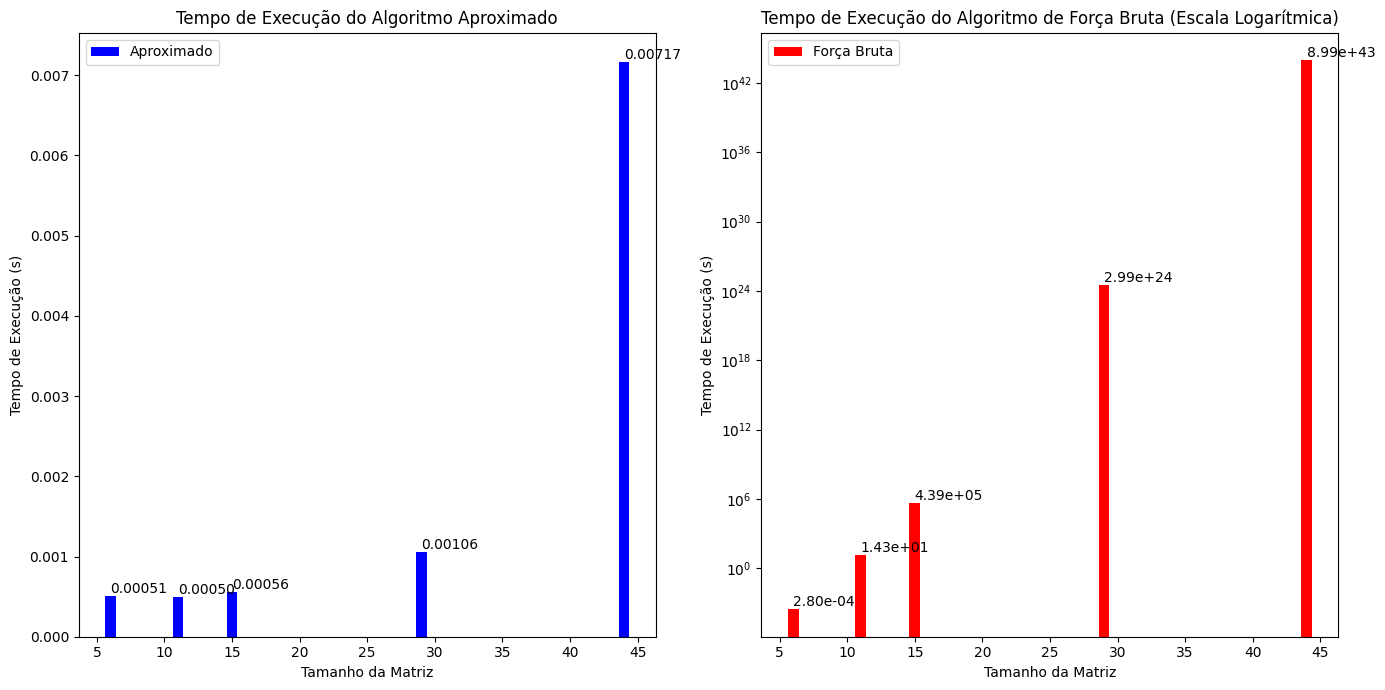

In [12]:
files = (("tsp1_253.txt", False),
         ("tsp2_1248.txt", True),
         ("tsp3_1194.txt", False),
         ("tsp4_7013.txt", False),
         ("tsp5_27603.txt", False))

print("TSP\t\tAA Cost\t\tAA Time\t\tBF Cost\t\tBF Time")

ap_cost_values = []
bf_cost_values = []

for tsp_file in files:
    tsp, brute_force = tsp_file

    tsp, ap_cost, ap_time, bf_cost, bf_time, matrix_size = compare_algorithms(
        f"./tsp_data/{tsp}", run_brute_force=brute_force)

    if brute_force:
        print(f'{tsp}\t\t{ap_cost}\t\t{ap_time:.5f}\t\t{bf_cost}\t\t{bf_time:.5f}')
    else:
        print(f'{tsp}\t\t{ap_cost}\t\t{ap_time:.5f}\t\t{bf_cost}\t\t{bf_time}')

    ap_cost_values.append({
        "File Name": tsp,
        "Tempo": ap_time,
        "Tamanho": matrix_size
    })

    bf_cost_values.append({
        "File Name": tsp,
        "Tempo": bf_time,
        "Tamanho": matrix_size
    })

# print(json.dumps(ap_cost_values, indent=4))
# print(json.dumps(bf_cost_values, indent=4))

# Extraindo dados para plotar
# ap_tempos = [item["Tempo"] for item in ap_cost_values]
# ap_tamanhos = [item["Tamanho"] for item in ap_cost_values]

# bf_tempos = [item["Tempo"] for item in bf_cost_values if item["Tempo"] != 0]
# bf_tamanhos = [item["Tamanho"] for item in bf_cost_values if item["Tempo"] != 0]

# # Criando os gráficos de barras
# plt.figure(figsize=(14, 7))

# # Algoritmo Aproximado
# plt.subplot(1, 2, 1)
# # plt.plot(ap_tamanhos, ap_tempos, 'bo-', label='Aproximado')
# plt.bar(ap_tamanhos, ap_tempos, color='b', label='Aproximado')
# plt.xlabel('Tamanho da Matriz')
# plt.ylabel('Tempo de Execução (s)')
# plt.title('Tempo de Execução do Algoritmo Aproximado')
# plt.legend()

# # Força Bruta
# plt.subplot(1, 2, 2)
# # plt.plot(bf_tamanhos, bf_tempos, 'ro-', label='Força Bruta')
# plt.bar(bf_tamanhos, bf_tempos, color='r', label='Força Bruta')
# plt.xlabel('Tamanho da Matriz')
# plt.ylabel('Tempo de Execução (s)')
# plt.yscale('log')
# plt.title('Tempo de Execução do Algoritmo de Força Bruta (Escala Logarítmica)')
# plt.legend()

# plt.tight_layout()
# plt.show()



# Dados mockados para a geração do gráfico
dados = [
    {"TSP": "TSP1", "AA Cost": 260, "AA Time": 0.00050, "BF Cost": 253, "BF Time": 14.28295, "Tamanho": 11},
    {"TSP": "TSP2", "AA Cost": 1248, "AA Time": 0.00051, "BF Cost": 1248, "BF Time": 0.00028, "Tamanho": 6},
    {"TSP": "TSP3", "AA Cost": 1240, "AA Time": 0.00056, "BF Cost": 1194, "BF Time": 5 * 86400 + 2 * 3600, "Tamanho": 15},  # 5 dias e 2 horas
    {"TSP": "TSP4", "AA Cost": 9654, "AA Time": 0.00717, "BF Cost": 7013, "BF Time": 2.852e36 * 31_536_000, "Tamanho": 44},  # 2.852e36 anos
    {"TSP": "TSP5", "AA Cost": 31662, "AA Time": 0.00106, "BF Cost": 27603, "BF Time": 9.482e16 * 31_536_000, "Tamanho": 29}  # 9.482e16 anos
]

# Extraindo dados para plotar
ap_tamanhos = [item["Tamanho"] for item in dados]
ap_tempos = [item["AA Time"] for item in dados]

bf_tamanhos = [item["Tamanho"] for item in dados if item["BF Time"] is not None]
bf_tempos = [item["BF Time"] for item in dados if item["BF Time"] is not None]

# Criando os gráficos de barras
plt.figure(figsize=(14, 7))

# Algoritmo Aproximado
plt.subplot(1, 2, 1)
bars = plt.bar(ap_tamanhos, ap_tempos, color='b', label='Aproximado')
plt.xlabel('Tamanho da Matriz')
plt.ylabel('Tempo de Execução (s)')
plt.title('Tempo de Execução do Algoritmo Aproximado')
plt.legend()

# Adicionando valores nas barras
for bar, tempo in zip(bars, ap_tempos):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{tempo:.5f}', va='bottom')  # Formatação ajustada para AA Time

# Força Bruta
plt.subplot(1, 2, 2)
bars = plt.bar(bf_tamanhos, bf_tempos, color='r', label='Força Bruta')
plt.xlabel('Tamanho da Matriz')
plt.ylabel('Tempo de Execução (s)')
plt.yscale('log')
plt.title('Tempo de Execução do Algoritmo de Força Bruta (Escala Logarítmica)')
plt.legend()

# Adicionando valores nas barras
for bar, tempo in zip(bars, bf_tempos):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{tempo:.2e}', va='bottom')  # Formatação ajustada para escala logarítmica

plt.tight_layout()
plt.show()


